In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
spike_data_binned = np.load('/Users/linggeli/neuroscience/data/spike_data_binned.npy')
trial_info = np.load('/Users/linggeli/neuroscience/data/trial_info.npy')

In [47]:
print(spike_data_binned.shape)

(245, 46, 400)


In [7]:
rat_correct = trial_info[:, 0] == 1
in_sequence = trial_info[:, 1] == 1
not_odor_e = trial_info[:, 3] < 5
select = rat_correct & in_sequence & not_odor_e

In [8]:
decoding_start = 210
decoding_end = decoding_start + 25

In [56]:
decoding_data_spike = np.mean(spike_data_binned[select, :, decoding_start:decoding_end], axis=2)
decoding_target = trial_info[select, 3] - 1

In [59]:
print(np.mean(decoding_data_spike, axis=0))
print(np.std(decoding_data_spike, axis=0))

[7.33333333e-03 2.04761905e-03 0.00000000e+00 9.14285714e-03
 8.61904762e-03 9.11904762e-03 2.16666667e-03 1.09523810e-03
 4.02380952e-03 1.16666667e-03 5.71428571e-04 1.19047619e-04
 6.40476190e-03 1.37857143e-02 3.09523810e-04 2.14285714e-04
 1.10238095e-02 1.02857143e-02 2.85714286e-04 2.14285714e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.86904762e-02
 3.38095238e-03 1.09761905e-02 3.64285714e-03 6.57142857e-03
 9.52380952e-05 1.19047619e-04 2.38095238e-05 1.20000000e-02
 1.23571429e-02 4.61904762e-03 2.52380952e-03 1.90476190e-04
 3.80952381e-04 1.19047619e-04 1.19047619e-04 1.68809524e-02
 2.38095238e-05 2.95238095e-03 1.19047619e-04 1.45238095e-03
 7.97619048e-03 3.57142857e-04]
[0.00496975 0.00311641 0.         0.00617434 0.0059038  0.01221183
 0.00517971 0.00233819 0.00479081 0.00248248 0.00170633 0.00080777
 0.00512956 0.01067939 0.00106878 0.00117586 0.00732246 0.00777752
 0.00111879 0.00100085 0.         0.         0.         0.00776435
 0.00420856 0.00685909 0.0039

In [22]:
print(decoding_data_spike.shape)
print(decoding_target.shape)

(168, 46)
(168,)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [31]:
from sklearn.cross_validation import KFold, StratifiedKFold

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler()
training = scaler.fit_transform(decoding_data_spike)
target = decoding_target

In [64]:
kf = StratifiedKFold(target, n_folds=10)
overall_acc = []
y_total = np.zeros(target.shape)
y_hat_total = np.zeros(target.shape)
i = 0
for train_index, test_index in kf:
    X_train, X_test = training[train_index, :], training[test_index, :]
    y_train, y_test = target[train_index], target[test_index]
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.1)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    n_k = y_hat.shape[0]
    y_total[i:(i + n_k)] = y_test
    y_hat_total[i:(i + n_k)] = y_hat
    i += n_k
    accuracy = np.mean(y_hat == y_test)
    print('Current fold accuracy: {acc}'.format(acc=accuracy))
    overall_acc.append(accuracy)
print(np.mean(np.asarray(overall_acc)))

Current fold accuracy: 0.684210526316
Current fold accuracy: 0.5
Current fold accuracy: 0.647058823529
Current fold accuracy: 0.823529411765
Current fold accuracy: 0.823529411765
Current fold accuracy: 0.705882352941
Current fold accuracy: 0.647058823529
Current fold accuracy: 0.625
Current fold accuracy: 0.866666666667
Current fold accuracy: 0.733333333333
0.7056269349845201


In [65]:
decoder = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.1)
decoder.fit(training, target)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
decoding_alignment = np.load('/Users/linggeli/neuroscience/sandbox/decoding_alignment.npy')

In [154]:
duration = decoding_alignment[:, 1] - decoding_alignment[:, 0]
duration = duration[duration > 0]
np.mean(duration) * 1000

36.26190476192598

In [43]:
trial_idx = 10

In [55]:
print(decoding_target[trial_idx])

0


In [77]:
data_spike = spike_data_binned[select]
print(data_spike.shape)

(168, 46, 400)


In [85]:
def align_rolling(trial_idx, time_idx, data_spike, scaler, decoder):
    rolling_hat = np.zeros((20, 4))
    for i in range(20):
        current_start = time_idx - 20 + i * 2
        current_end = current_start + 25
        current_window = np.expand_dims(data_spike[trial_idx, :, current_start:current_end], axis=0)
        current_data = scaler.transform(np.mean(current_window, axis=2))
        current_hat = decoder.predict_proba(current_data)
        rolling_hat[i, :] = current_hat
    return rolling_hat

In [193]:
trial_set = np.where(decoding_target == 0)[0]
rolling_set = []
for i, trial_idx in enumerate(trial_set):
    time_idx = int(decoding_alignment[trial_idx, 0] * 100) + 200
    if time_idx > 200 and time_idx < 355:
        rolling_set.append(align_rolling(trial_idx, time_idx, data_spike, scaler, decoder))
rolling_set = np.stack(rolling_set)

In [165]:
from matplotlib import patches
from matplotlib import rcParams
plt.style.use('seaborn-white')
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Georgia'

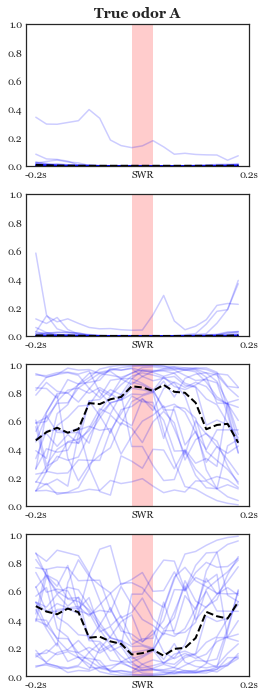

In [194]:
fig = plt.figure(figsize=(4, 12))

ax = plt.subplot(411)
for i in range(rolling_set.shape[0]):
    plt.plot(rolling_set[i, :, 0], color='blue', alpha=0.2)
plt.plot(np.median(rolling_set[:, :, 0], axis=0), color='black', lw=2, ls='--')
rect1 = patches.Rectangle((9, 0), 2, 1, linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)
ax.add_patch(rect1)
plt.xticks([0, 10, 20], ['-0.2s', 'SWR', '0.2s'])
plt.ylim(0, 1)
plt.title('True odor A', fontsize=14, fontweight='bold')

ax = plt.subplot(412)
for i in range(rolling_set.shape[0]):
    plt.plot(rolling_set[i, :, 1], color='blue', alpha=0.2)
plt.plot(np.median(rolling_set[:, :, 1], axis=0), color='black', lw=2, ls='--')
rect1 = patches.Rectangle((9, 0), 2, 1, linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)
ax.add_patch(rect1)
plt.xticks([0, 10, 20], ['-0.2s', 'SWR', '0.2s'])
plt.ylim(0, 1)

ax = plt.subplot(413)
for i in range(rolling_set.shape[0]):
    plt.plot(rolling_set[i, :, 2], color='blue', alpha=0.2)
plt.plot(np.median(rolling_set[:, :, 2], axis=0), color='black', lw=2, ls='--')
rect1 = patches.Rectangle((9, 0), 2, 1, linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)
ax.add_patch(rect1)
plt.xticks([0, 10, 20], ['-0.2s', 'SWR', '0.2s'])
plt.ylim(0, 1)

ax = plt.subplot(414)
for i in range(rolling_set.shape[0]):
    plt.plot(rolling_set[i, :, 3], color='blue', alpha=0.2)
plt.plot(np.median(rolling_set[:, :, 3], axis=0), color='black', lw=2, ls='--')
rect1 = patches.Rectangle((9, 0), 2, 1, linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)
ax.add_patch(rect1)
plt.xticks([0, 10, 20], ['-0.2s', 'SWR', '0.2s'])
plt.ylim(0, 1)

plt.savefig('/Users/linggeli/Desktop/swr_A.png', dpi=300)
plt.show()

In [39]:
window_size = 25
stride = 10
n_trial, n_neuron, n_timebin = data_X.shape
n_example = (n_timebin - window_size) / stride
all_pred = np.zeros((n_trial, n_example, 5))
for i in range(n_example):
    window_start = i * stride
    window_end = i * stride + window_size
    test_data = np.mean(data_X[:, :, window_start:window_end], axis=2)
    pred = decoder.predict_proba(test_data)
    all_pred[:, i, :] = pred

In [40]:
import matplotlib.patches as patches

In [41]:
def plot_by_odor(odor_index, all_pred, target):
    """Plot predictions for all trials of the same odor.
    
    Args:
        odor_index: (int) odor by which to group
        all_pred: 3d numpy array of format [trial, time, odor]
        target: 2d numpy array of format [trial, odor]
    """
    odor_names = ['A', 'B', 'C', 'D', 'E']
    pred_by_odor = all_pred[(target[:, odor_index] == 1), :, :]
    n_trial = pred_by_odor.shape[0]
    fig = plt.figure(figsize=(20, 3), dpi=200)
    for j in range(5):
        ax = plt.subplot(int('15' + str(j + 1)))
        plt.xticks([9.5, 19.5, 29.5], ['-1s', '0s', '1s'])
        plt.ylim(0, 1)
        rect1 = patches.Rectangle((21, 0), 2.5, 1, linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)
        ax.add_patch(rect1)
        ax.text(5, 0.75, r'$P({})$'.format(odor_names[j]), fontsize=14)
        for i in range(n_trial):
            plt.plot(pred_by_odor[i, :, j], color='blue', alpha=0.1)
    plt.suptitle('True odor ' + odor_names[odor_index], fontsize=14, fontweight='bold')
    plt.show()

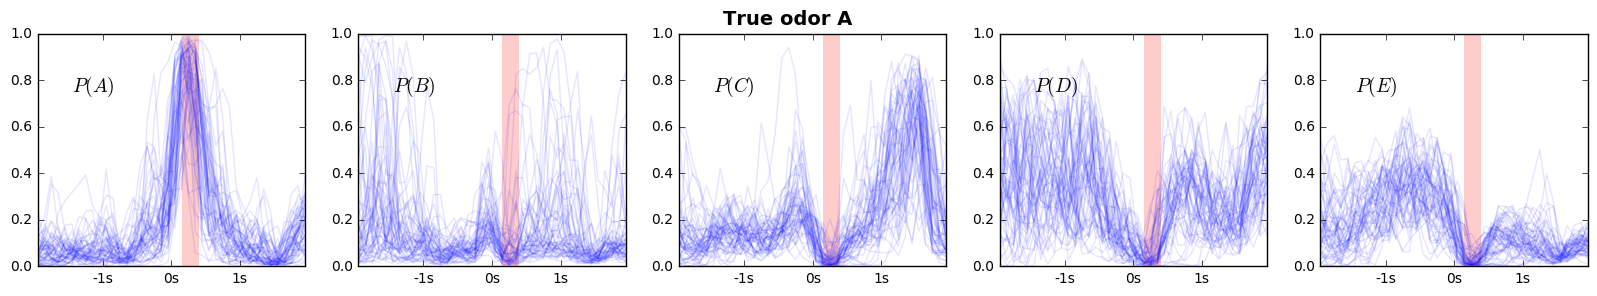

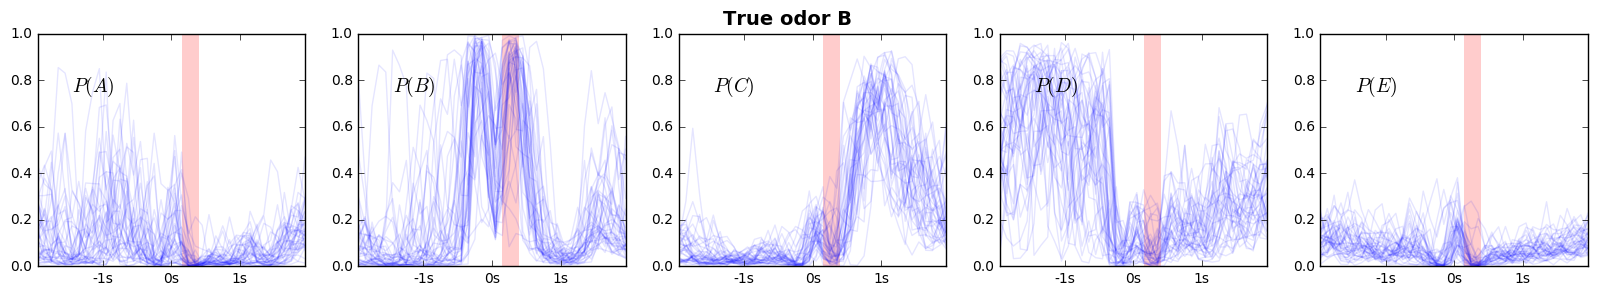

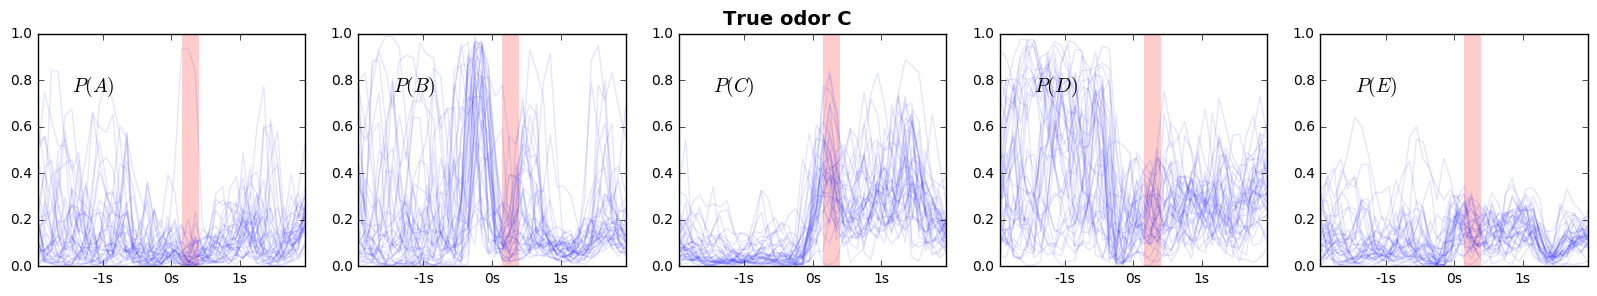

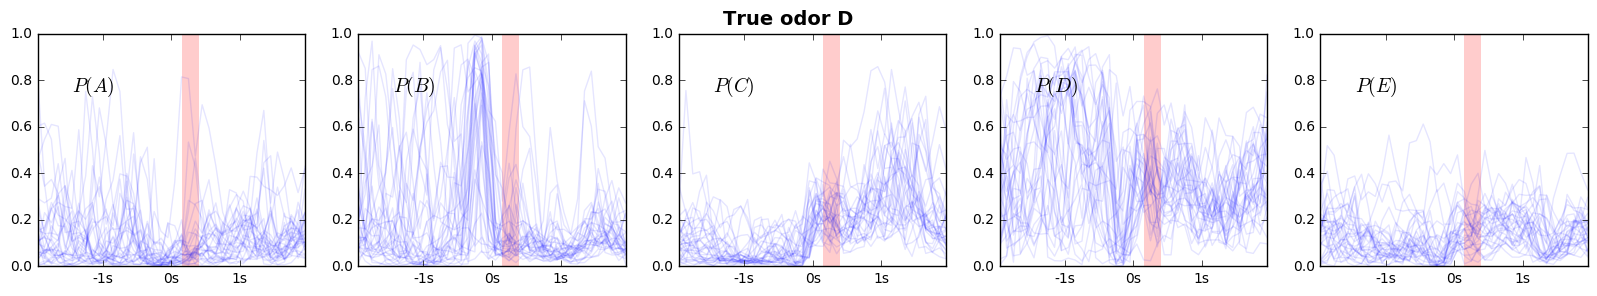

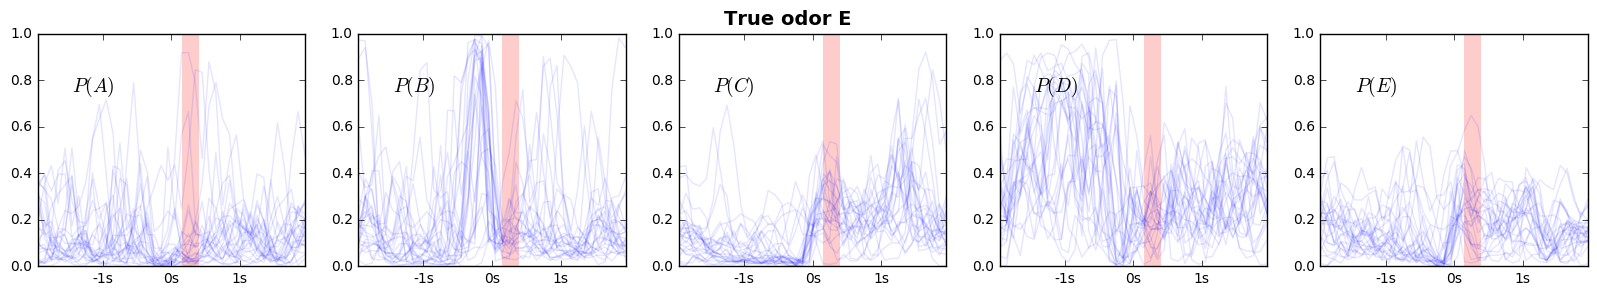

In [42]:
plot_by_odor(0, all_pred, target)
plot_by_odor(1, all_pred, target)
plot_by_odor(2, all_pred, target)
plot_by_odor(3, all_pred, target)
plot_by_odor(4, all_pred, target)